# $t$ Test

In [1]:
from imprint.nb_util import setup_nb

# setup_nb is a handy function for setting up some nice plotting defaults.
setup_nb()
import scipy.stats
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np

import imprint as ip
from imprint.models.ttest import TTest1D

In this tutorial, we visit the standard t-test.
Consider the data $X_1,\ldots, X_n$ i.i.d. where $X_i \sim \mathcal{N}(\mu, \sigma^2)$
for unknown $\mu$ and $\sigma$.
We wish to test the hypothesis 
$$H_0: \mu \leq \mu_0$$
for some fixed $\mu_0$.
Under the natural parameter $\theta = (\frac{\mu}{\sigma^2}, -\frac{1}{2\sigma^2})$, the null hypothesis can be reparametrized as
$$H_0: \theta_1 \leq -2 \mu_0 \theta_2$$

The t-test constructs the test statistic:
$$
\begin{align*}
    T &:= \frac{\sqrt{n}(\bar{X} - \mu_0)}{S} \\
    S &:= \sqrt{\frac{\sum\limits_{i=1}^n (X_i - \bar{X})^2}{n-1}}
\end{align*}
$$

Note that under any $(\mu, \sigma)$, 
$$
\begin{align*}
    \bar{X} &\sim \mathcal{N}\left(\mu, \frac{\sigma^2}{n}\right) \\
    S &\sim \sqrt{\frac{\sigma^2 \chi^2_{n-1}}{n-1}}
\end{align*}
$$
Hence, the test statistic can be written as:
$$
\begin{align*}
    T &\equiv 
    \frac{Z + \sqrt{n}\frac{\mu-\mu_0}{\sigma}}{\sqrt{\frac{W}{n-1}}}
\end{align*}
$$
where $Z \sim \mathcal{N}(0,1)$ and $W \sim \chi^2_{n-1}$ independent.

We first initialize a few configuration variables.

In [2]:
mu_0 = 0  # fixed threshold for null hypothesis
theta_min = [-1, -1]  # minimum for theta
theta_max = [0, -0.1]  # maximum for theta
n_samples = 20  # number of Gaussian draws
n_gridpts = [200, 200]  # number of grid-points along each direction
alpha = 0.025  # target nominal level
n_sims = 8192  # number of simulations

# true critical threshold in the lambda space
lam = -scipy.stats.t.isf(alpha, df=n_samples - 1)

Next, we construct the grid.

In [3]:
grid = ip.cartesian_grid(
    theta_min=theta_min,
    theta_max=theta_max,
    n=n_gridpts,
    null_hypos=[ip.hypo(f"theta0 <= {-2 * mu_0} * theta1")],
)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=40000, worker_id=1, t=1675807314, n_bits=18, worker_bits=18) = [4480137286184599552 4480137286184599553 4480137286184599554, ...]:
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.


We now run the validation procedure for the t-test model.

In [4]:
rej_df = ip.validate(
    TTest1D,
    g=grid,
    lam=lam,
    K=n_sims,
    model_kwargs={"n_samples": n_samples, "mu0": mu_0},
)
rej_df.tail()

,tie_sum,tie_est,tie_cp_bound,tie_bound,K
39995,119,0.014526,0.017907,0.023201,8192
39996,135,0.016479,0.020055,0.025862,8192
39997,153,0.018677,0.022458,0.028823,8192
39998,175,0.021362,0.025378,0.032403,8192
39999,192,0.023438,0.027624,0.035143,8192


Next, we compute the true Type I Error for comparison.

In [5]:
# compute true TIE
def true_tie(theta, mu_0, n_samples, crit_thresh):
    sig = jnp.sqrt(-0.5 / theta[1])
    mu_div_sig = theta[0] * sig
    mu_0_div_sig = mu_0 / sig
    shift = jnp.sqrt(n_samples) * (mu_div_sig - mu_0_div_sig)
    df = n_samples - 1
    factor = crit_thresh / jnp.sqrt(df)
    xs = jnp.logspace(0, 10, 1000)

    def integrand(x):
        return (
            1 - jax.scipy.stats.norm.cdf(factor * jnp.sqrt(x) - shift)
        ) * jax.scipy.stats.chi2.pdf(x, df)

    ys = jax.vmap(integrand, in_axes=(0,))(xs)

    return jnp.trapz(ys, xs)


true_tie_vmap = jax.vmap(true_tie, in_axes=(0, None, None, None))
rej_df["true_tie"] = true_tie_vmap(grid.get_theta(), mu_0, n_samples, -lam)

Finally, we plot the true Type I Error and compare with the simulation estimates.
For the true Type I Error, we also plot the level-curves for which the signal-to-noise ratio is constant as a sanity check.

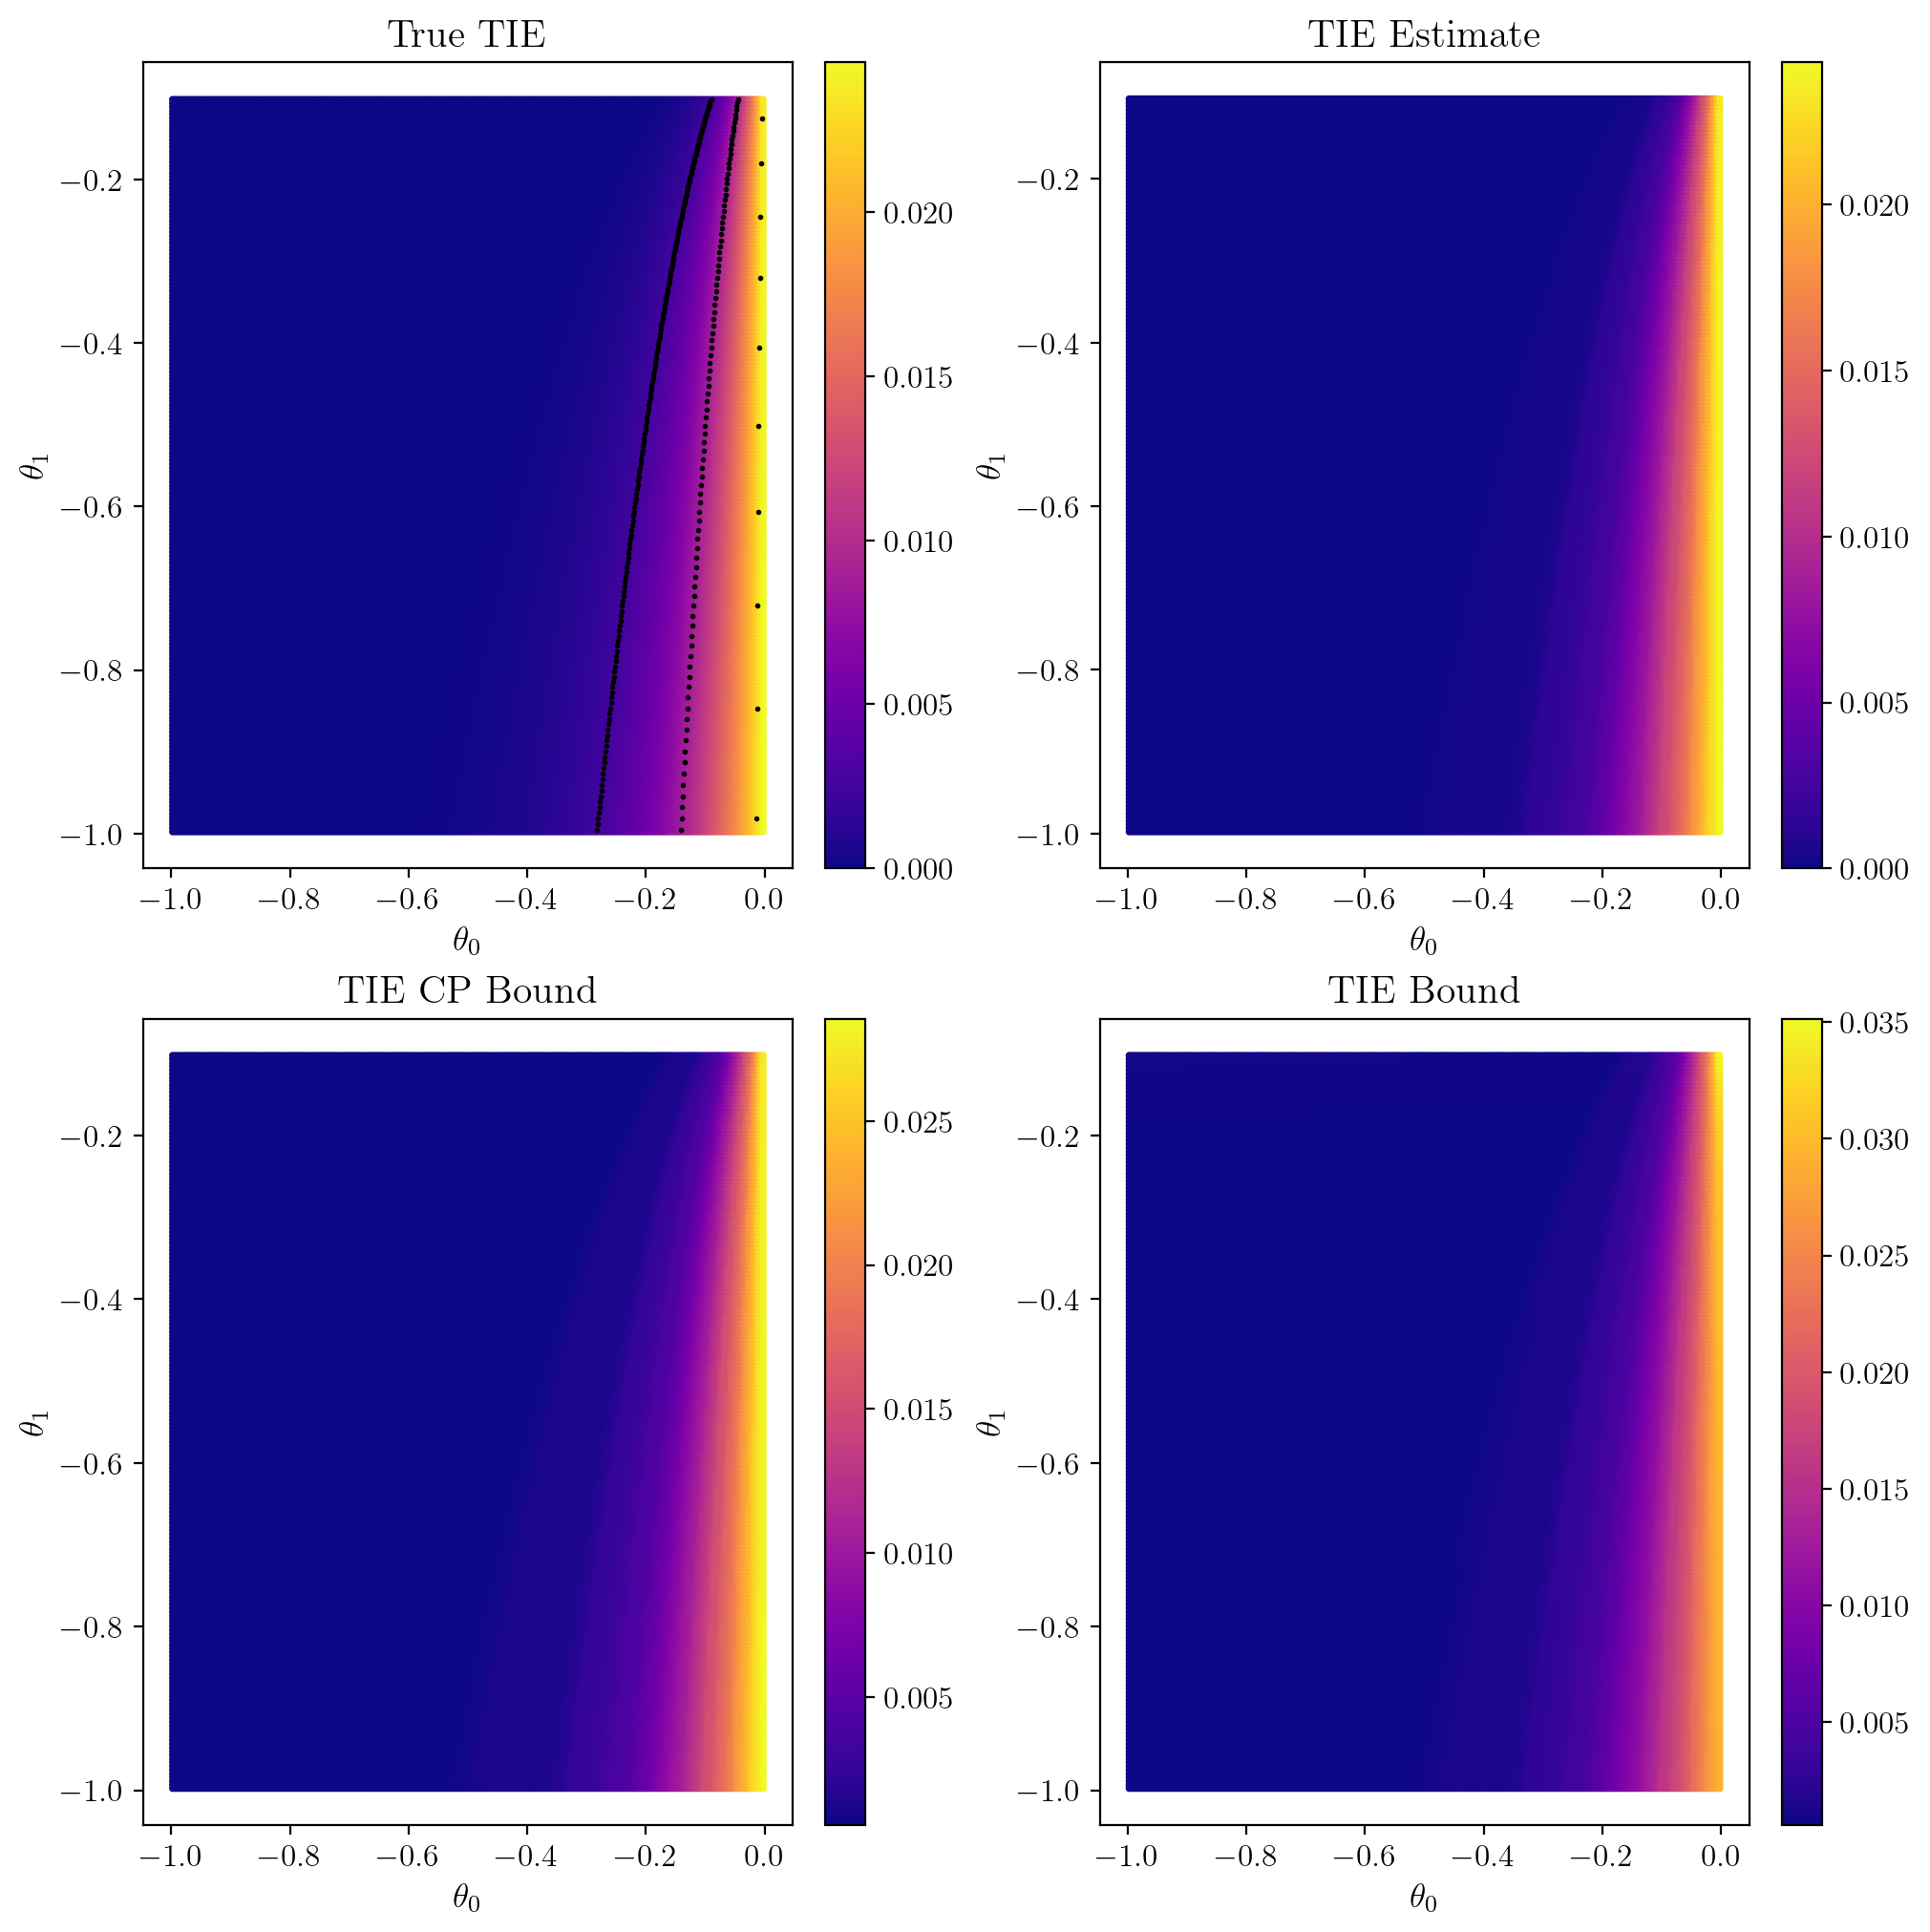

In [6]:
s = 3
plt.figure(figsize=(10, 10), constrained_layout=True)
names = ["true_tie", "tie_est", "tie_cp_bound", "tie_bound"]
titles = ["True TIE", "TIE Estimate", "TIE CP Bound", "TIE Bound"]
for i, (name, title) in enumerate(zip(names, titles)):
    plt.subplot(2, 2, i + 1)
    plt.title(title)
    plt.scatter(grid.df["theta0"], grid.df["theta1"], c=rej_df[name], s=s)
    plt.colorbar()
    plt.xlabel(r"$\theta_0$")
    plt.ylabel(r"$\theta_1$")

# plot signal-to-noise ratio profile
plt.subplot(2, 2, 1)
snrs = [0.01, 0.1, 0.2]
for snr in snrs:
    theta0s = np.linspace(theta_min[0], theta_max[0], 1000)
    theta1s = -0.5 / snr**2 * theta0s**2
    subset = (theta1s >= theta_min[1]) & (theta1s <= theta_max[1])
    theta0s, theta1s = theta0s[subset], theta1s[subset]
    plt.scatter(theta0s, theta1s, c="black", s=1)

plt.show()